In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
import base64
import string
import re
from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from pywaffle import Waffle

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.collocations import *
try:
    stopwords = set(stopwords.words('english'))
except LookupError:
    import nltk
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))
#stopwords
import csv
import io
import spacy
import numpy as np

In [3]:
%matplotlib inline

In [4]:
#Pour Sophie
def creation_csv(nom_livre,numero_livre):
    chemin = r"C:\Users\Sophie\Harry-Python\Data\Book " + numero_livre + " - " + nom_livre + ".txt"
    sortie = r"C:\Users\Sophie\Harry-Python\Data\book" + numero_livre + ".csv"
    with io.open(chemin,"r",encoding="utf-8") as infile, open(sortie, 'w',encoding = 'utf-8-sig') as outfile:
        stripped = (line.strip() for line in infile)
        lines = (line.split(",") for line in stripped if line)
        writer = csv.writer(outfile)
        writer.writerows(lines)

In [5]:
#On crée un dictionnaire
Books = {'The Philosophers Stone': '1',
        'The Chamber of Secrets': '2',
        'The Prisoner of Azkaban': '3',
        'The Goblet of Fire':'4',
        'The Order of the Phoenix': '5',
        'The Half Blood Prince': '6',
        'The Deathly Hallows': '7'}

In [6]:
#Pour Sophie
#On fait une boucle exécutant la fonction sur chaque élément du dictionnaire
Books_csv = {}
for title, i in Books.items():
    creation_csv(title, i)
    Books_csv['book' + i] = pd.read_csv(r"C:\Users\Sophie\Harry-Python\Data\book" + i + ".csv" ,encoding = 'utf-8-sig', sep='delimiter', header=None)

<ipython-input-6-1664f9427c7a>:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  Books_csv['book' + i] = pd.read_csv(r"C:\Users\Sophie\Harry-Python\Data\book" + i + ".csv" ,encoding = 'utf-8-sig', sep='delimiter', header=None)


In [7]:
# Créer un tableau avec tous les livres
df_books = pd.DataFrame(Books_csv.items(), columns = ['Books', 'Text'])
df_books

,Books,Text
0,book1,...
1,book2,...
2,book3,...
3,book4,...
4,book5,...
5,book6,...
6,book7,...


In [8]:
#On veut éliminer le numéro de page hyper relou
import re
pattern = ["Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Philosophers Stone[\s]?-[\s]?J.K. Rowling",
           "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Chamber of Secrets[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Prisoner of Azkaban[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Goblet of Fire[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[l0-9]?[lOU0-9]?[lOU0-9]?[lOU0-9][\s]?Harry Potter and the Order of the Phoenix[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Half Blood Prince[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Deathly Hallows[\s]?-[\s]?J.K. Rowling"]

In [9]:
def clean_page(text, pattern):
    for ele in pattern:
        liste_regex = re.findall(ele, text, re.IGNORECASE)
        for expression in liste_regex:
            text = text.replace(expression, '')
    return text

In [10]:
#Création du même dictionnaire mais avec texte fusionné pour chaque tome
all_text = Books_csv.copy()
for i in Books_csv:
    all_text[i] = ' '.join([text for text in Books_csv[i][0]])

In [11]:
#Application de la fonction au dictionnaire des livres
for i in all_text:
    all_text[i] = clean_page(all_text[i], pattern)

In [13]:
#nltk.download('punkt')
all_text_clean = all_text.copy()

for i in all_text:
    
    text_list = nltk.tokenize.word_tokenize(all_text[i])
    text_list = [x.lower() for x in text_list]
    text_clean = [w.lower() for w in text_list if w not in stopwords and w.isalpha()]
    text_clean = ' '.join(text.lower() for text in text_clean)
    all_text_clean[i] = text_clean

In [15]:
#package pour l'analyse des sentiments
#!pip install vaderSentiment
#? vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [16]:
sentiment_model = SentimentIntensityAnalyzer()
phrases = [
    "Our Saturday classes and fun and super interesting!",
    "Make sure you :) or :D today!",
    "The book was great, I enjoyed it very much.",
    "At least it isn't a horrible book.",
    "I got a very bad grade on my homework.",
    "Today is a really terrible day :("
]
for phrase in phrases:
    # on obtient le score de la phrase
    scores = sentiment_model.polarity_scores(phrase)
    print (scores)
    
    # print the sentence and sentiment
    print(phrase)
    
    # the {: <15} characters just tell python to add spaces between columns
    print("negative: {: <15} neutral: {: <15} positive: {: <15} compound: {}\n".format(
        scores['neg'], scores['neu'], scores['pos'], scores['compound']
    ))

{'neg': 0.0, 'neu': 0.329, 'pos': 0.671, 'compound': 0.8805}
Our Saturday classes and fun and super interesting!
negative: 0.0             neutral: 0.329           positive: 0.671           compound: 0.8805

{'neg': 0.0, 'neu': 0.294, 'pos': 0.706, 'compound': 0.8633}
Make sure you :) or :D today!
negative: 0.0             neutral: 0.294           positive: 0.706           compound: 0.8633

{'neg': 0.0, 'neu': 0.486, 'pos': 0.514, 'compound': 0.8126}
The book was great, I enjoyed it very much.
negative: 0.0             neutral: 0.486           positive: 0.514           compound: 0.8126

{'neg': 0.0, 'neu': 0.678, 'pos': 0.322, 'compound': 0.431}
At least it isn't a horrible book.
negative: 0.0             neutral: 0.678           positive: 0.322           compound: 0.431

{'neg': 0.322, 'neu': 0.678, 'pos': 0.0, 'compound': -0.5849}
I got a very bad grade on my homework.
negative: 0.322           neutral: 0.678           positive: 0.0             compound: -0.5849

{'neg': 0.567, 'neu'

On obtient la proportion du texte qui est positive, négative ou neutre. Un mot extrêmement positif sera associé à la valeur 1, un mot extrêmement négatif à 0. Compound donne la somme des notes de chaque mot.

In [17]:
#pour chaque livre, on calcule le score de sentiments positifs

book_scores = []
for i in all_text_clean:

    words = nltk.word_tokenize(all_text_clean[str(i)])

    # on regarde le score de chaque mot et on les somme
    all_scores = []    
    for word in words:
        scores = sentiment_model.polarity_scores(word)
        compound_score = scores['compound']
        all_scores.append(compound_score)

    # on fait la moyenne pour chaque livre à partir du score de chaque mot
    book_score = sum(all_scores) / len(all_scores)
    book_scores.append(book_score)

In [18]:
print(book_scores)

[0.005374916733952407, 0.0030386115115892047, 0.003553512159850472, 0.0044260720376837455, 0.0038894091718745046, 0.0067082858604412664, -0.000797572314567129]


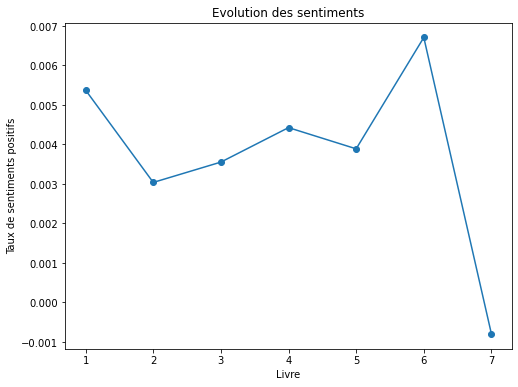

In [19]:
#on fait un graphe de la positvité des sentiments selon le livre
x = np.linspace(1,7,7)
plt.figure(figsize=(8,6))
plt.plot(x, book_scores, marker = 'o', label = 'Positivité des sentiments')
plt.title('Evolution des sentiments')
plt.xlabel('Livre')
plt.ylabel('Taux de sentiments positifs')
plt.show()

Comme on étudie des romans, la plupart des mots sont neutres ce qui explique que les taux soient très proches de 0. Il est intéressant alors de comparer les livres entre eux, mais les scores en eux-mêmes ne sont pas très intéressants.
On va alors essayer de ne pas prendre en compte les mots neutres.

In [20]:
book_scores_2 = []
for i in all_text_clean:

    words = nltk.word_tokenize(all_text_clean[str(i)])

    # on regarde le score de chaque mot et on les somme
    all_scores = []    
    for word in words:
        if sentiment_model.polarity_scores(word)['neu'] == 0: #on garde que ceux où le score neutre est nul
            scores = sentiment_model.polarity_scores(word)
            compound_score = scores['compound']
            all_scores.append(compound_score)

        # on fait la moyenne pour chaque livre à partir du score de chaque mot
    book_score = sum(all_scores) / len(all_scores)
    book_scores_2.append(book_score)

In [21]:
print(book_scores_2)

[0.046258132464712665, 0.025635441616766334, 0.02947123007166905, 0.03568681345665873, 0.03014775639150511, 0.0490693511353002, -0.006135129094412444]


On constate que l'on a des résultats moins proches de 0.

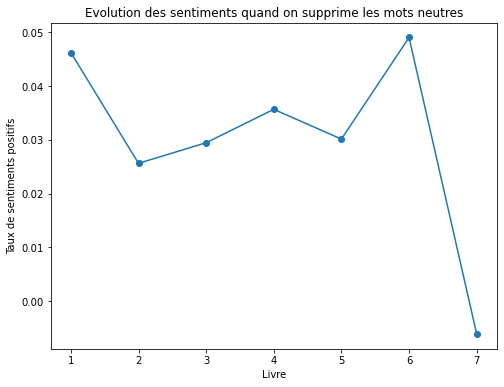

In [45]:
x = np.linspace(1,7,7)
plt.figure(figsize=(8,6))
plt.plot(x, book_scores_2, marker = 'o', label = 'Positivité des sentiments')
plt.title('Evolution des sentiments quand on supprime les mots neutres')
plt.xlabel('Livre')
plt.ylabel('Taux de sentiments positifs')
plt.show()

La courbe est la même que dans le cas avec les mots neutres, seule l'échelle est changée. En effet, les mots neutres n'affectaient pas le score car dans le "compound", ils valaient 0. Si l'on peut analyser les différences entre les livres, on ne peut pas en sortir de tendance nette en termes de positivité des sentiments car les valeurs restent tout de même proches de 0.

In [22]:
#Travail sur la relation entre personnages
all_text_clean_list = all_text_clean.copy()
for i in all_text_clean:
    all_text_clean_list[i] = all_text_clean[i].split()


harry = ['harry potter', 'harry']
ron = ['ron weasley', 'ron']
hermione = ['hermione granger','hermione']
ginny = ['ginny weasley', 'ginny']
dumbledore = ['albus dumbledore', 'dumbledore']
sirius = ['sirius black', 'sirius']
snape = ['severus snape', 'snape']
luna = ['luna lovegood', 'luna']
hagrid = ['rubeus hagrid', 'hagrid']
dobby = ['dobby']
voldemort = ['tom riddle', 'voldemort', 'you-know-who', 'know-who', 'lord']
draco = ['draco malfoy', 'draco', 'malfoy']

In [23]:
#Fonction récupérant l'index de chaque apparition d'un personnage
def occurence(text_list, perso):
    occurence_all = []
    for i in text_list:
        occurence = []
        for idex, word in enumerate(text_list[i]):
            if word in perso:
                occurence.append(idex)
        occurence_all.append(occurence)
    return occurence_all

In [27]:
harry_occ = occurence(all_text_clean_list, harry)
ron_occ = occurence(all_text_clean_list, ron)
hermione_occ = occurence(all_text_clean_list, hermione)
ginny_occ = occurence(all_text_clean_list, ginny)
dumbledore_occ = occurence(all_text_clean_list, dumbledore)
sirius_occ = occurence(all_text_clean_list, sirius)
snape_occ = occurence(all_text_clean_list, snape)
luna_occ = occurence(all_text_clean_list, luna)
hagrid_occ = occurence(all_text_clean_list, hagrid)
dobby_occ = occurence(all_text_clean_list, dobby)
voldemort_occ = occurence(all_text_clean_list, voldemort)
draco_occ = occurence(all_text_clean_list, draco)

harry_occ[0] donne les index des occurences du premier livre.

In [82]:
#je mets pas harry
persos_occ_1 = [ron_occ[0],hermione_occ[0],ginny_occ[0],dumbledore_occ[0],snape_occ[0],hagrid_occ[0],voldemort_occ[0],draco_occ[0]]

In [25]:
all_scores = []
for idx in harry_occ[0]:
    idx_bas = idx - 20
    idx_haut = idx + 20
    grp = [word for word in all_text_clean_list['book1'][idx_bas:idx_haut]]
    grp_join = ' '.join(grp)
    score = sentiment_model.polarity_scores(grp_join)
    compound_score = score['compound']
    all_scores.append(compound_score)
all_scores

[-0.128,
 -0.2263,
 -0.5719,
 0.5106,
 -0.9501,
 -0.9773,
 -0.3566,
 0.1027,
 0.8078,
 0.25,
 0.25,
 0.9578,
 0.9153,
 0.8555,
 -0.8402,
 0.2263,
 -0.34,
 0.8481,
 0.836,
 0.0,
 0.8126,
 0.0,
 0.5994,
 0.93,
 0.5574,
 0.4767,
 -0.2263,
 -0.296,
 -0.296,
 -0.296,
 0.4588,
 0.4404,
 0.802,
 -0.4404,
 0.5267,
 0.5267,
 0.3612,
 0.3612,
 0.3612,
 0.4627,
 0.5267,
 -0.7845,
 -0.7845,
 -0.34,
 -0.7003,
 -0.8225,
 -0.8225,
 0.1531,
 0.7269,
 -0.802,
 0.7351,
 0.1779,
 -0.2263,
 -0.34,
 0.128,
 0.0772,
 -0.8689,
 -0.0516,
 0.8658,
 0.8957,
 0.1027,
 -0.5994,
 -0.296,
 0.5352,
 0.4404,
 0.4404,
 0.4404,
 0.7783,
 0.5423,
 -0.1531,
 -0.2023,
 0.796,
 0.4576,
 0.8658,
 0.7717,
 -0.8834,
 -0.2023,
 -0.2023,
 0.3102,
 0.3102,
 0.7063,
 0.7063,
 0.2254,
 -0.2273,
 0.1779,
 0.1779,
 0.1027,
 0.0772,
 0.8807,
 -0.7003,
 -0.8126,
 -0.8591,
 -0.8176,
 -0.5106,
 0.3031,
 0.4767,
 -0.7214,
 -0.674,
 -0.8271,
 -0.802,
 -0.7717,
 0.8004,
 0.8004,
 0.802,
 0.8422,
 0.705,
 -0.785,
 -0.5279,
 0.8519,
 0.7351,

In [68]:
def sentiment_rel(perso_pdv, perso_cible):   #les arguments sont les listes d'index trouvées précédemment
    #boucler sur les livres
    all_book_score = []
    all_score = []
    list_index = []
    for idx in perso_pdv:
        #on considère que deux personnages ont une interaction s'ils sont à moins de 40 mots d'écart
        idx_bas = idx - 40
        idx_haut = idx + 40
        
        for index in perso_cible: 
            if (idx_bas <= index <= idx_haut):
                    #liens += 1                     #si les index sont proches, on incrémante le compteur de liens
                list_index.append([idx, index])
    grp = [word for word in all_text_clean_list['book1'][min([idx, index])-20:max([idx, index])+20]] #i au lieu de book1
    grp_join = ' '.join(grp)
    score = sentiment_model.polarity_scores(grp_join)
    #print(score)
    compound_score = score['compound']
    all_score.append(compound_score)
    #all_book_score.append(all_score)
    return all_score

In [69]:
sentiment_rel(draco_occ[0],harry_occ[0])

[0.988]

In [91]:
scores_persos = []
for perso in persos_occ_1:
    scores_persos.append(sentiment_rel(harry_occ[0],perso))
scores_persos

[[0.8402], [0.8402], [0.3798], [0.9882], [0.9825], [0.9098], [0.9988], [0.988]]

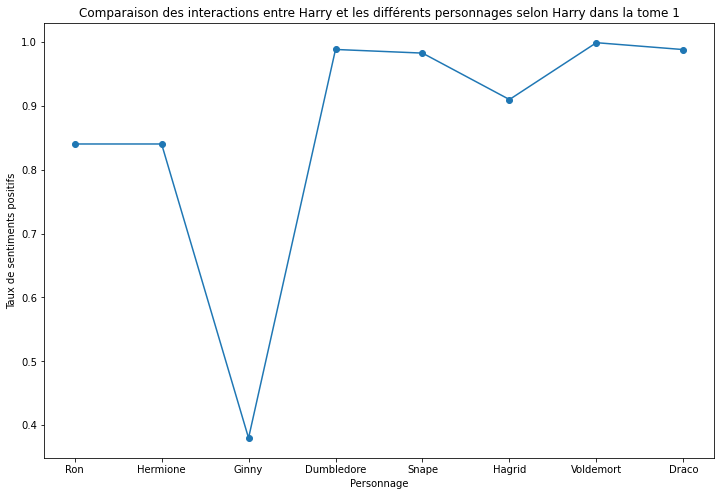

In [92]:
x = ["Ron","Hermione","Ginny","Dumbledore","Snape","Hagrid","Voldemort","Draco"]
plt.figure(figsize=(12,8))
plt.plot(x, scores_persos, marker = 'o', label = 'Positivité des interactions selon Harry')
plt.title('Comparaison des interactions entre Harry et les différents personnages selon Harry dans la tome 1')
plt.xlabel('Personnage')
plt.ylabel('Taux de sentiments positifs')
plt.show()

Idée: il faudrait pondérer selon le nombre d'apparitions (Ginny n'apparait qu'une fois c'est normal que son score soit très négatif).